In [39]:
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import cluster
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import Descriptors
from sklearn.preprocessing import StandardScaler
import warnings
from rdkit.Chem import AllChem

In [ ]:
class Cluster_Sampling:
    def __init__(self, df, smiles_column):
        self.smiles_column = smiles_column
        self.df = df[[smiles_column]]
        other_columns = [col for col in df.columns if col != smiles_column]
        if other_columns:
            warnings.warn("Columns other than the SMILES column will be dropped: " + ", ".join(other_columns))
        

    def standardize_smiles(self, smiles,desalt,remove_stereo):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        try:
            if desalt:
                frags = Chem.GetMolFrags(mol, asMols=True)
                mol = max(frags, key=lambda m: m.GetNumAtoms())
                # Need to neutralize function group after remove charge
            if remove_stereo:
                Chem.RemoveStereochemistry(mol)
            
            Chem.SanitizeMol(mol)
            return Chem.MolToSmiles(mol, canonical=True)
        
        except Exception as e:
            print(f"Error in standardizing {smiles}: {str(e)}")
            return mol 
        

    def smile_standardizer(self,desalt=True,remove_stereo=True):
        tqdm.pandas()
        self.df['standardized_smiles'] = self.df[self.smiles_column].progress_apply(lambda smiles: self.standardize_smiles(smiles,desalt=desalt,remove_stereo=remove_stereo))

    def get_mol_object(self):
        self.df['mol'] = self.df['standardized_smiles'].apply(Chem.MolFromSmiles)

    def get_properties(self):
        self.df['MolWt'] = self.df['mol'].apply(Descriptors.MolWt)
        self.df['MolLogP'] = self.df['mol'].apply(Descriptors.MolLogP)
        self.df['NumHDonors'] = self.df['mol'].apply(Descriptors.NumHDonors)
        self.df['NumHAcceptors'] = self.df['mol'].apply(Descriptors.NumHAcceptors)
        self.df['TPSA'] = self.df['mol'].apply(Descriptors.TPSA)
        self.df['NumRotatableBonds'] = self.df['mol'].apply(Descriptors.NumRotatableBonds)
        self.df['RingCount'] = self.df['mol'].apply(Descriptors.RingCount)
        self.df['HeavyAtomCount'] = self.df['mol'].apply(Descriptors.HeavyAtomCount)
        self.df['FractionCSP3'] = self.df['mol'].apply(Descriptors.FractionCSP3)
        self.df['FormalCharge'] = self.df['mol'].apply(Chem.GetFormalCharge)
        # Add more property as you want
        
        self.prop_array = self.df.drop([self.smiles_column,'mol','standardized_smiles'], axis=1).to_numpy()
    
    def scaling(self):
        self.scaler = StandardScaler()
        self.standard_prop_array = self.scaler.fit_transform(self.prop_array)

    def get_morgan_fp(self, radius = 2, n_bits=2048):
        fps = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits) for mol in self.df['mol']]
        self.df['morgan_fp'] = fps
        self.morgan_fp = np.array([np.array(fp) for fp in fps], dtype=int)


    def pca_decomposition(self, n_components = 600):
        pca = PCA(n_components=n_components)
        self.morgan_pca = pca.fit_transform(self.morgan_fp)

    def clustering(self):
        pass

    def sampling(self):
        pass

In [36]:
df = pd.read_csv("../data/sample_data.csv")

In [64]:
cluster_sampling = Cluster_Sampling(df,smiles_column='SMILE')
cluster_sampling.smile_standardizer()
cluster_sampling.get_mol_object()
cluster_sampling.get_properties()
cluster_sampling.scaling()
cluster_sampling.get_morgan_fp()

/var/folders/xg/drggnx1n5cv7mnctplfkwlzh0000gn/T/ipykernel_38104/1947156100.py:7: UserWarning: Columns other than the SMILES column will be dropped: Unnamed: 0, ID, MOL, Activity, MolLogP, MolWt, HBD, HBA, NumAromaticRings, NumRotatableBonds, TPSA, MolMR, BertzCT, BalabanJ, FpDensityMorgan1, FpDensityMorgan2, FpDensityMorgan3, FractionCSP3, HeavyAtomCount, HeavyAtomWt, RingCount
  warnings.warn("Columns other than the SMILES column will be dropped: " + ", ".join(other_columns))
100%|██████████| 10019/10019 [00:02<00:00, 3495.95it/s]
/var/folders/xg/drggnx1n5cv7mnctplfkwlzh0000gn/T/ipykernel_38104/1947156100.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['standardized_smiles'] = self.df[self.smiles_column].progress_apply(lambda smile

In [65]:
cluster_sampling.pca_decomposition()

In [71]:
cluster_sampling.morgan_pca[:,1].std()

0.8305595876002766

In [59]:
pca.explained_variance_ratio_.sum()

0.7978579167189573

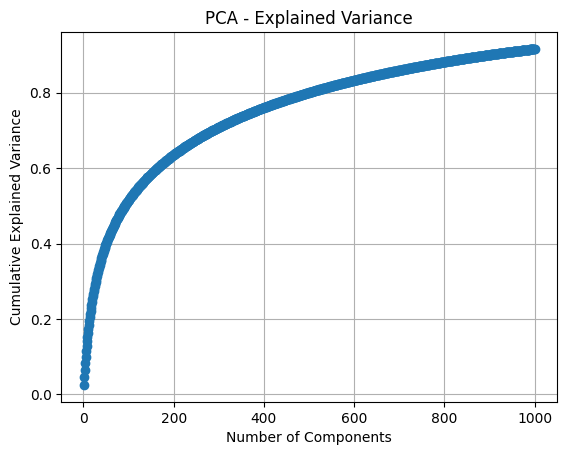

Elbow point at component: 2


In [56]:
import numpy as np
import matplotlib.pyplot as plt
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance vs. components
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.show()

# Find the elbow point using the second derivative
second_derivative = np.diff(cumulative_variance, 2)
elbow_point = np.argmax(second_derivative < 0) + 2  # Add 2 to index since diff reduces size by 2

print(f"Elbow point at component: {elbow_point}")